# CS441 Final Project

#### Matthew Bass

In this project I will look at different AVP connection models and compare their period and order when simulated in complete darkness.


---

### Setup

In [1]:
# Imports
import numpy as np
from scipy import integrate
import scipy.stats
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

#### Code to plot Network

In [2]:
def plot_network(conn, N, half, rows, cols, title=None):
    VIP_count = int(0.1*N)
    AVP_count = int(0.2*N)
    AVP_skip = 3 # 1/0.2/2 (20% of cells, but only shell cells and shell cells are 50% of cells. so it would be every 5th cell overall, but instead is every 2.5th so round to every 3rd
    plt.figure()
    for i in range(N):
        r1,c1 = np.unravel_index( i, (rows,cols))
        for j in range(N):
            if conn[i,j] > 0:
                r2,c2 = np.unravel_index( j, (rows,cols))
#                 plt.plot( (c1,c2), (r1,r2), 'k-' )
                if c1 > c2:
                    # arrow goes from c2 to c1, so it goes from right to left
                    cdiff = c1-c2-0.05
                elif c1 == c2:
                    cdiff = c1-c2
                else:
                    cdiff = c1-c2+0.05
                if r1 > r2:
                    # arrow goes from r2 to r1, so it goes up
                    rdiff = r1-r2-0.05
                elif r1 == r2:
                    rdiff = r1-r2
                else:
                    rdiff = r1-r2+0.05
#                 plt.arrow( c2, r2, cdiff, rdiff, color='k', alpha=0.5, head_width=0.1 )

                x1 = c2
                y1 = r2
                x2 = c2+cdiff
                y2 = r2+rdiff
                style = "Simple, tail_width=0.5, head_width=4, head_length=8"
                kw = dict(arrowstyle=style, color="k", alpha=0.5)
                arrow = patches.FancyArrowPatch((x1, y1), (x2, y2),
                             connectionstyle="arc3,rad=.25", **kw)
                plt.gca().add_patch(arrow)
        if i < half:
            plt.plot( c1, r1, 'ro')
            # VIP cells are 10% of the cells and they are clustered in the core
            if i < VIP_count:
                plt.plot( c1, r1, 'yv' )
        else:
            plt.plot( c1, r1, 'bo')
            # AVP cells are 20% of the cells and they are spread out throughout the shell
            if np.mod(i-half, AVP_skip) == 0:
                plt.plot( c1, r1, 'm^' )
        if title is not None:
            plt.title(title)

#### Function for Order Parameter

In [3]:
def orderParameter( phases ):
    z = np.nanmean( np.exp(1j*phases))
    r = np.abs(z)
    return r

#### Function for Period

In [4]:
def get_period(t,x):
    """ Approximate the period of a 1-D x, given the time-steps t.
        Returns a tuple with the period and the standard deviation of the period over time.
        Note that this is meant for the estimates of MP - i.e. it isn't meant for
        phases. We are using this so that we can use the same methods of analysis
        That we would use for data. Also, it works better for computing the over all period
        (i.e. analyze the mean MP for all neurons)."""
    idxs = scipy.signal.find_peaks(x)
    idxs = idxs[0]
    times = t[idxs]
    period = np.mean(np.diff(times));
    sdperiod = np.sqrt(np.var(np.diff(times)));
    return (period,sdperiod)

#### Function for DD simulation

In [40]:
def DD(t):
    return 0

def simulate_DD( N, model_fn, min_SI=0.8, debug=False ):
    ''' Given a model function, simulate in DD and find the period and order.
       We need the Sync Index (order parameter) to be at least min_SI for it to "work"
       Returns the y0 associated with CT0.
       For each cell, we compute the per mRNA output with the function sin(phi).
       CT0 is defined as 6 circadian hours before the peak of the mean per mRNA
    '''
    end_time = 400
    dt = 0.1
    ts = np.arange(0,end_time,dt)
    ps0 = np.zeros( (N,) )
    sol = integrate.solve_ivp( fun = model_fn, t_span = (0, end_time), y0=ps0,
                              method="LSODA", t_eval = ts, max_step=0.01, min_step=0.001 )
    NT = sol.t.size
    Rs = np.apply_along_axis( orderParameter, axis=1, arr=sol.y[:,NT//2:].T )
    MPs = np.sin(sol.y) # is NY x NT, sol.t is (NT,)
    # check the SI at the end of the simulation

#     print(f"shape of sol.y {sol.y.shape}")
#     print(f"shape of sol.t {sol.t.shape}")
    # print(NT)
    # print(Rs)
    #
    plt.plot(sol.t[NT//2:],np.sin(sol.y[:,NT//2:].T))
    plt.show()

    # if Rs[-1] < min_SI:
    #     return ps0, Rs, False
    mean_MP = MPs.mean( axis = 0 )
    period, sdperiod = get_period( sol.t[NT//2:], mean_MP[NT//2:] )

    return Rs.mean(), period, sol

#### The Model

##### The parameters object

In [6]:
class Parameters_VipAVPLight_v2:
    def __init__( self, N, VIPconn, AVPconn, intrinsic_periods = None,
                 VIP_start = 0, VIP_duration= np.pi/2,
                 AVP_VRC_shift=np.pi, AVP_start=np.pi, AVP_duration=np.pi/2,
                 lightInducedVIP_strength = 0, VIP_strength = 0, AVP_strength = 0,
                 light_fn = DD):
        half = N // 2
        if intrinsic_periods is None:
            np.random.seed( 0 )
            intrinsic_periods = np.random.randn( N ) * 0.5
            intrinsic_periods[:half] += 25
            intrinsic_periods[half:] += 24.4
        # Assume that VIP is sent during day (pretty confident about this assumption)
        VIP_active_start = VIP_start

#         VIP_active_stop = VIP_active_start+VIP_duration;
        VIP_active_stop = np.mod(VIP_active_start+VIP_duration, 2*np.pi)
        VIP_Darea = 0.5;
        # Assume that AVP is sent during day, just like VIP. Is that a good assumption?
        # AVP levels in cerebrospinal fluid higher in morning than at night (Reppert et al, Science 1981), so it might be fine.
        # This is something we can adjust
        AVP_active_start = AVP_start;
#         AVP_active_stop = AVP_active_start+AVP_duration;
        AVP_active_stop = np.mod( AVP_active_start+AVP_duration, 2*np.pi );
        AVP_Darea = 0.5;
        self.N = N
        self.VIPconn = VIPconn
        self.AVPconn = AVPconn
        self.VIPergic = np.any( VIPconn, axis=0 )
        self.AVPergic = np.any( AVPconn, axis=0 )
        self.light_fn = light_fn
        self.intrinsic_speeds = np.reshape( (2*np.pi)/intrinsic_periods, (N,) )
        self.params = np.array( [VIP_Darea, VIP_active_start, VIP_active_stop,
                                 AVP_Darea, AVP_VRC_shift, AVP_active_start,
                                 AVP_active_stop, lightInducedVIP_strength,
                                 VIP_strength, AVP_strength] )

##### The model function

In [7]:
# This is function SRT grabbed from her jetlag paper.
# It is more adjustable than we need at the moment, but we will
# use it regardless.
# VRC that adjusts the area under a cosine curve.
# for VIP, shift_rad should be 0 rad
# for AVP, the ideal shift_rad is pi (half out of phase)
def VRC_adjustable3(phi,Darea,Aarea,shift_rad):
    phase = np.mod(phi+shift_rad,2*np.pi)
    if phase >= np.pi/2 and phase < np.pi/2+np.pi:
        # in the delay section
        a = Darea/0.5
    else:
        # in the advance section
        a = Aarea/0.5;
    VRC = a * np.cos( phase )
    return VRC

# Model function to be used by solve_ivp
# t is a scalar (time)
# phi is the vector of phases for each cell
# pobj is the Parameters_VipAVPLight_v2 object
# New: VIP cells may send VIP when receive light, even if it
#      isn't during the usual VIP-sending phase
def model_vip_avp_light_v2(t,phi,pobj):
    N = pobj.N
    phi = np.mod(phi,2*np.pi);
    VIP_Darea = pobj.params[0] # fraction of total area
    VIP_Aarea = 1-VIP_Darea # fraction of total area
    VIP_active_start = pobj.params[1]
    VIP_active_stop = pobj.params[2]
    AVP_Darea = pobj.params[3] # fraction of total area
    AVP_Aarea = 1-VIP_Darea # fraction of total area
    AVP_VRC_shift = pobj.params[4]
    AVP_active_start = pobj.params[5]
    AVP_active_stop = pobj.params[6]
    lightInducedVIP_strength = pobj.params[7]
    VIP_strength = pobj.params[8]
    AVP_strength = pobj.params[9]

    speed = pobj.intrinsic_speeds

    # Determine which cells see light and how much
    light_input = pobj.light_fn(t)*pobj.VIPergic

    # Evaluate the VIP VRC at the phase for each of the oscillators
    VIP_VRC = np.array( [VRC_adjustable3(p,VIP_Darea,VIP_Aarea,0) for p in phi] ).reshape( (N,) )
    VIP_output = np.zeros( (N,) )

    # VIP_output[np.logical_and( VIP_active_start <= phi, phi <= VIP_active_stop )] = VIP_strength
    if VIP_active_start < VIP_active_stop:
        VIP_output[np.logical_and( VIP_active_start <= phi, phi <= VIP_active_stop )] = VIP_strength
    else:
        VIP_output[np.logical_or( VIP_active_stop <= phi, phi <= VIP_active_start )] = VIP_strength

    # NEW!!!
    # assuming all cells receive light, make it so cells release at least as much VIP
    # as light is inducing.
    # We rely on 2 assumptions - all VIP cells receive light and the network will make it so
    # we can't tell VIP is released from nonVIP cells
    VIP_output = np.fmax( VIP_output, lightInducedVIP_strength*light_input)
    VIP_output = pobj.VIPergic * VIP_output
    AVP_VRC = np.array( [VRC_adjustable3(p,AVP_Darea,AVP_Aarea,AVP_VRC_shift) for p in phi] ).reshape( (N,) )
    AVP_output = np.zeros( (N,) )
    #AVP_output[np.logical_and( AVP_active_start <= phi, phi <= AVP_active_stop )] = AVP_strength
    if AVP_active_start < AVP_active_stop:
        AVP_output[np.logical_and( AVP_active_start <= phi, phi <= AVP_active_stop )] = AVP_strength
    else:
        AVP_output[np.logical_or( AVP_active_stop <= phi, phi <= AVP_active_start )] = AVP_strength

    AVP_output = AVP_output * pobj.AVPergic

    # This code makes it look like we sum the input, but the connectivity matrix is set up so that
    # each entry has already been divided by the number of entries that send to a particular cell
    VIP_input = pobj.VIPconn @ VIP_output
    AVP_input = pobj.AVPconn @ AVP_output

    dydt = speed + VIP_VRC*(VIP_input+light_input) + AVP_VRC*AVP_input
    return dydt

#### VIP Connection

In [25]:
# 10% of cells are VIP, and they are in the core. no reason not to put them next to each other because there is no local network among them.
# each cell receives VIP from exactly one VIP cell
# The key difference between this model and v1 is that VIP cells
# signal each other.
# In this model, the averaging is built into the matrix. In the mechanistic model, it isn't
# indexing: to, from
def VIP_conn_v2( N, VIP_strength ):
    if VIP_strength < 1e-8:
        return np.zeros( (N,N) )
    VIPcount = int( 0.1*N)
    half = N // 2
    A = np.zeros( (N,N) )
    for i in range(VIPcount):
        # to, from
        # every nonVIP cell gets input from one VIP cell
        A[VIPcount+i::VIPcount,i] = VIP_strength
        # Each VIP cell gets input from its neighbor in a 
        # circle
        A[(i+1)%VIPcount,i] = VIP_strength
    denom = np.count_nonzero( A, axis=1 )
    for i in range(denom.size):
        if denom[i] > 0:
            A[i,:] = A[i,:] / denom[i]
    return A

def VIP_conn_v3( N ):
    VIPcount = int( 0.1*N)
    half = N // 2
    A = np.zeros( (N,N) )
    for i in range(VIPcount):
        # to, from
        # every nonVIP cell gets input from one VIP cell
        A[VIPcount+i::VIPcount,i] = 1
        # Each VIP cell gets input from its neighbor in a
        # circle
        A[(i+1)%VIPcount,i] = 1
    return A

#### AVP Connections


##### Adjacency matrix for AVP coupling network

The AVP coupling network is rather complicated, and we are going to need to make and vary assumptions about it. Let's start with the simplest set.

We know that about 20% of neurons in the SCN are AVPergic and that they are located in the shell (Ono et al, 2021), we will will spread those AVP cells throughout the second half of our network.

Further, the AVP network may be more local than the VIP network (though the evidence is NOT clear to SRT for this one). We will construct it so that AVP is sent to cells that are nearby in our 2D grid. This is another area of adjustment for the model.

*Reference*

Ono, D., Honma, K. I. & Honma, S. Roles of Neuropeptides, VIP and AVP, in the Mammalian Central Circadian Clock. Frontiers in Neuroscience 15, 1–8 (2021).

In [8]:
# 20% of cells are AVP, and they are in the shell. make them every 3rd cell.
# Construct an AVP network with only local coupling a nbrhood_size of 1
# means that each AVP cell sends a signal to its neighbors 1 way up/down/left/right/diagonal
# nbrhood size of 2 means that more than half of the cells receive AVP
# There is not
def AVP_conn_v1( N, nbrhood_size = 2 ):
    rows = int(np.sqrt(N))
    cols = int(N/rows)
    half = N//2
    AVP_count = int(0.2*N)
    AVP_skip = 3 # 1/0.2/2 (20% of cells, but only shell cells and shell cells are 50% of cells. so it would be every 5th cell overall, but instead is every 2.5th so round to every 3rd
    AVPconn = np.zeros( (N,N) )
    #for j in range(half,half+AVP_count): # AVP cells at beginning of shell
    for j in range(half,N, AVP_skip): # AVP cells spread throughout shell
        # from nodes.
        r,c = np.unravel_index( j, (rows,cols) )
        neighbors = []
        for nridx in range(nbrhood_size+1):
            for ncidx in range(nbrhood_size+1):
                if nridx == 0 and ncidx == 0:
                    continue # no self-signaling
                neighbors.extend([(r-nridx,c-ncidx),(r+nridx,c+ncidx)])
        for nbr in neighbors:
            if nbr[0] >= 0 and nbr[0] < rows and nbr[1] >= 0 and nbr[1] < cols:
                i = np.ravel_multi_index( nbr, (rows,cols) )
                AVPconn[i,j] = 1
    return AVPconn

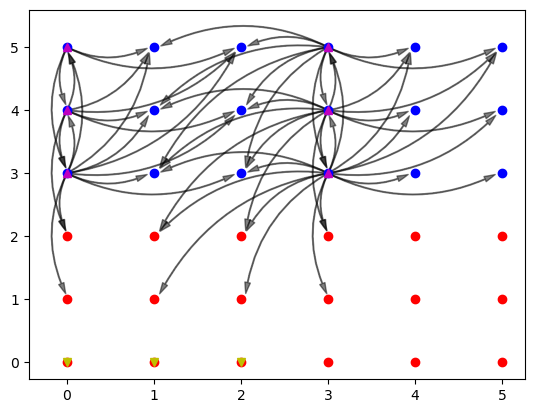

In [9]:
N = 36
AVP_strength = 0.3
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

AVPconn = AVP_conn_v1( N)
plot_network( AVPconn, N, half, rows, cols )
plt.show()

#### AVP Ring Connection

Here the AVP cells are connected in a one directional ring. This model is quite simplistic but can be used to test the effect of AVP on the network.

In [10]:
def avp_ring_conn( N ):
    AVPconn = np.zeros( (N,N) )
    for i in range(N):
        AVPconn[i,np.mod(i-1,N)] = 1
    return AVPconn

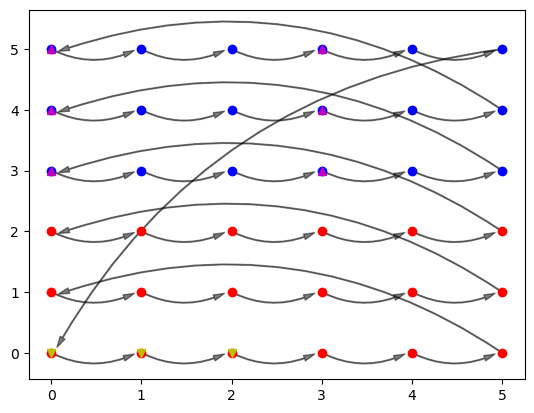

In [11]:
N = 36
AVP_strength = 0.3
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

AVPconn = avp_ring_conn( N)
plot_network( AVPconn, N, half, rows, cols )
plt.show()

#### AVP Skip Connection

In [12]:

def AVP_conn_skip(N,avp_skip=3):
    rows = int(np.sqrt(N))
    cols = int(N / rows)
    half = N // 2
    AVPconn = np.zeros((N, N))

    for j in range(half, N, avp_skip):
        r, c = np.unravel_index(j, (rows, cols))
        neighbors = []
        for nridx in range(-1, 2):
            for ncidx in range(-1, 2):
                if nridx == 0 and ncidx == 0:
                    continue
                nbr = (r + nridx, c + ncidx)
                if 0 <= nbr[0] < rows and 0 <= nbr[1] < cols:
                    i = np.ravel_multi_index(nbr, (rows, cols))
                    neighbors.append(i)
        for nbr in neighbors:
            AVPconn[nbr, j] = 1

    return AVPconn


### Running Connections in DD

#### DD with AVP Connection v1

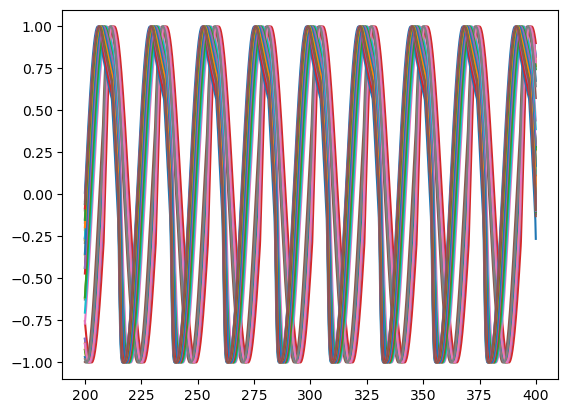

The order is 0.7834322663383642 and the period is 23.125


In [42]:
N = 36
AVP_strength = 0.3
VIP_strength = 0.25
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)
VIPconn = VIP_conn_v3(N)
AVPconn = AVP_conn_v1( N)
pobj = Parameters_VipAVPLight_v2(N, VIPconn, AVPconn, AVP_strength=AVP_strength, VIP_strength = VIP_strength)
model = lambda t,phi: model_vip_avp_light_v2(t,phi,pobj)

order, period, sol = simulate_DD( N, model, debug=True )

print(f"The order is {order} and the period is {period}")

#### DD with AVP Ring Connection

In [ ]:
N = 36
AVP_strength = 0.3
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

AVPconn = avp_ring_conn( N)
pobj = Parameters_VipAVPLight_v2(N, np.zeros((N,N)), AVPconn, AVP_strength=AVP_strength)
model = lambda t,phi: model_vip_avp_light_v2(t,phi,pobj)

order, period, sol = simulate_DD( N, model, debug=True )

print(f"The order is {order} and the period is {period}")

#### DD with AVP Skip Connection

In [16]:
N = 36
AVP_strength = 0
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

AVPconn = AVP_conn_skip( N)
pobj = Parameters_VipAVPLight_v2(N, np.zeros((N,N)), AVPconn, AVP_strength=AVP_strength)
model = lambda t,phi: model_vip_avp_light_v2(t,phi,pobj)

order, period, sol = simulate_DD( N, model, debug=True )

print(f"The order is {order} and the period is {period}")

The order is 0.018767290566875195 and the period is 25.371428571428574


Find the ideal AVP strength for each network

Can try different values along the different networks

Can also maybe vary nwighborhood size